### Load Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [10]:
!python --version

Python 3.10.12


In [11]:
print('numpy: ' + np.__version__)
print('torch: ' + torch.__version__)
print('torchvision: ' + torchvision.__version__)
print('matplotlib: ' + matplotlib.__version__)
print('pandas: ' + pd.__version__)

numpy: 1.25.2
torch: 2.3.1+cu121
torchvision: 0.18.1+cu121
matplotlib: 3.7.1
pandas: 2.0.3


In [13]:
import random

# Set random seed for reproduciibility
manualSeed = 2020
# manualSeed = random.randint(1, 10000) # use if you want new results
print('Random Seed: ', manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2020


In [14]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


### MNIST dataset download

In [15]:
# hyper-parameter
batch_size = 64

In [16]:
# standardizer for preprocessing MNIST dataset
standardizer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)])

In [17]:
# MNIST dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 1988569.72it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344874.23it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3180695.60it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5608044.97it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [18]:
# dataloader for load images in batch_size
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

In [19]:
# function for visualization
def tc_imshow(img, lbl=""):
  if img.size(0) == 1:
    plt.imshow(img.squeeze(), cmap="gray")
  else:
    plt.imshow(np.transpose(img, (1, 2, 0)))

  plt.title(lbl)
  plt.axis('off')

- if img.size(0) == 1 -> 이미지의 첫 번째 차원이 1인지를 확인. 즉, 흑백이미지인지 확인. img.squeeze()는 차원 중 사이즈가 1인 차원을 제거하여 2D이미지를 만든다. plt.imshow()는 이미지를 matplotlib를 이용해 표시하는 코드  
- else -> 컬러이미지. 이 경우에는 np.transpose()로 이미지의 차원을 재배치한다. 기본적으로 이미지 데이터는 (채널, 높이, 너비)의 순서로 되어있지만, matplotlib는 (높이, 너비, 채널)순으로 이미지를 받아들인다.

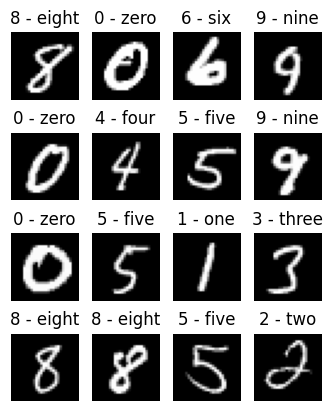

In [48]:
# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16):
  plt.subplot(4, 4, i+1)
  tc_imshow(img=mini_batch_img[i],
            lbl=train_data.classes[mini_batch_lbl[i].numpy()])
  plt.axis('off')

plt.savefig('../result/1-dataloader-example.png', dpi=300)

In [38]:
# check variables for practice
lst = [1, 2, 3, 4]
it = iter(lst)
print(next(it))
print(next(it))

print(mini_batch_lbl[2])
print(train_data.classes)
print(train_data.classes[mini_batch_lbl[2].numpy()])

1
2
tensor(9)
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
9 - nine


### Random sample $z$ from normal distribution

In [39]:
# hyper-parameter
dim_noise = 100 # dimension of latent space z

In [40]:
# Random sampling from normal distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
  return torch.randn(batch_size, dim_noise, device=device)

In [53]:
# Random sampling
z = random_sample_z_space(batch_size)
print("z: ", z.shape)

z:  torch.Size([64, 100])


### Generative model $G$

- `dim_hidden` : Number of hidden layer channels in the network
- `sz_output` : Width and height of the final output image (pixels)
- `num_channels` : Number of channels in input image

In [42]:
# hyper-parameter
dim_hidden = 256
sz_output = 28
num_channels = 1

In [44]:
dim_output = sz_output**2 # 28x28=784
img_shape = (num_channels, sz_output, sz_output) # (1, 28, 28)

In [47]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(dim_noise, dim_hidden),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_hidden),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_output),
        nn.Tanh(),
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *img_shape)
    return img

`*img_shape` : *(asterisk)는 python에서 사용되는 unpacking 구문이다.
img_shape는 tuple이며 (1,28,28)의 형태인데, *img_shape는 tuple내의 각 요소를 하나씩 꺼내어 함수나 method의 인자로 전달하는 역할을 한다.
img.view(img.size(0), *img_shape)는 실제로는 img.view(img.size(0), 3, 64, 64)와 같은 효과를 가진다.


In [54]:
G = Generator().to(device)

print("z: ", z.shape)
print("G(z): ", G(z).size())

z:  torch.Size([64, 100])
G(z):  torch.Size([64, 1, 28, 28])


In [55]:
# visualize
utils.save_image(G(z)[:35].cpu().detach(), '../result/2-G(z).png', nrow=5, normalize=True)

` G(z)[:35]` : 생성된 가짜 이미지 중에서 35개 선택  
`.cpu()` : 이미지를 cpu 메모리로 이동. GPU에서 계산한 결과를 cpu로 복사하여 사용할 때 필요한 작업  
`.detach()` : autograd 연산 추적을 멈추고 이미지 tensor를 새로운 tensor로 분리(detach). tensor를 수정하거나 연산 그래프에 추가적인 연산을 방지하기 위해 사용

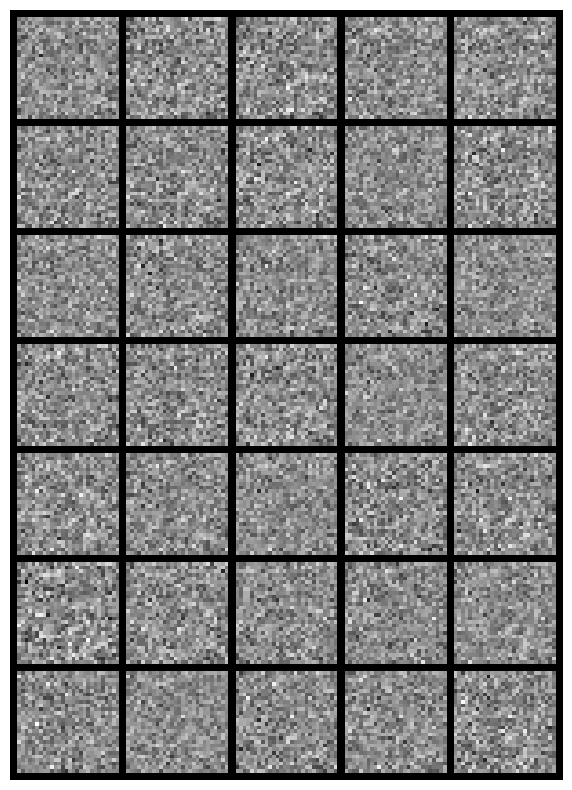

In [56]:
from PIL import Image

image_path = '../result/2-G(z).png'

# 이미지 열기
img = Image.open(image_path)

# 이미지 보기
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()

### Discriminative model $D$

In [57]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(dim_output, dim_hidden),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, dim_hidden),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.1),
        nn.Linear(dim_hidden, 1),
        nn.Sigmoid(),
    )

  def forward(self, img):
    flat_img = img.view(img.size(0), -1)
    check_validity = self.model(flat_img)

    return check_validity

In [59]:
D = Discriminator().to(device)

print("z: ", z.shape)
print("G(z): ", G(z).size())
print("D(G(z)): ", D(G(z)).size())

z:  torch.Size([64, 100])
G(z):  torch.Size([64, 1, 28, 28])
D(G(z)):  torch.Size([64, 1])


Defined discriminative model $D$  which architecture is like innverse of generative model $G$

The output of $D$ is a sigmoid function to discriminate fake and real image

### Train model $G$ and $D$

**Initialize model $G$ and $D$**

In [60]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

**Loss functions & Optimizers**

In [61]:
# hyper-parameter
learning_rate = 0.0002
beta1 = 0.9 # momentum parameter for Adam optimizer

In [62]:
adversarial_loss = nn.BCELoss()

In [63]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

**Train models**

In [64]:
# hyper-parameters
num_epochs = 200
interval_save_img = 1000 # Define the interval to save the image creation results. Images are saved at a certain batch size, allowing to check the learning process of the generated model.

In [65]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

In [70]:
losses = []

for idx_epoch in range(num_epochs):
  for idx_batch, (imgs, _) in enumerate(train_data_loader):
    # Ground truth variables indicating real/fake
    real_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
    fake_ground_truth = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

    # Real image
    real_imgs = Variable(imgs.type(Tensor))

    # -------------------
    # Train Generator
    # -------------------

    optimizer_G.zero_grad()

    # Random sample noise
    z = random_sample_z_space(imgs.size(0))

    # Generate image
    gen_imgs = generator(z)

    # Generator's loss: loss between D(G(z)) and real ground truth
    loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)

    loss_G.backward()
    optimizer_G.step()

    # -------------------
    # Train Discriminator
    # -------------------

    optimizer_D.zero_grad()

    loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
    loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
    loss_D = (loss_real + loss_fake) / 2

    loss_D.backward()
    optimizer_D.step()

    # -------------------
    # archieve loss
    # -------------------
    losses.append([loss_G.item(), loss_D.item()])

    # Print progress
    if idx_batch % 150 == 0:
      print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs, idx_batch, len(train_data_loader), loss_G, loss_D))

    batches_done = idx_epoch * len(train_data_loader) + idx_batch
    if batches_done % interval_save_img == 0:
      utils.save_image(gen_imgs.data[:25], '../result/3-{}.png'.format(batches_done), nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/938] loss_G: 5.745199, loss_D: 0.053135
[Epoch 0/200] [Batch 150/938] loss_G: 4.766624, loss_D: 0.041841
[Epoch 0/200] [Batch 300/938] loss_G: 3.750556, loss_D: 0.073375
[Epoch 0/200] [Batch 450/938] loss_G: 4.979291, loss_D: 0.054812
[Epoch 0/200] [Batch 600/938] loss_G: 4.506029, loss_D: 0.067478
[Epoch 0/200] [Batch 750/938] loss_G: 5.890420, loss_D: 0.080543
[Epoch 0/200] [Batch 900/938] loss_G: 4.372169, loss_D: 0.037861
[Epoch 1/200] [Batch 0/938] loss_G: 5.582062, loss_D: 0.081383
[Epoch 1/200] [Batch 150/938] loss_G: 4.951756, loss_D: 0.070585
[Epoch 1/200] [Batch 300/938] loss_G: 4.407252, loss_D: 0.053537
[Epoch 1/200] [Batch 450/938] loss_G: 7.287940, loss_D: 0.014991
[Epoch 1/200] [Batch 600/938] loss_G: 5.366159, loss_D: 0.043558
[Epoch 1/200] [Batch 750/938] loss_G: 5.220449, loss_D: 0.114792
[Epoch 1/200] [Batch 900/938] loss_G: 5.805271, loss_D: 0.082411
[Epoch 2/200] [Batch 0/938] loss_G: 4.558563, loss_D: 0.019990
[Epoch 2/200] [Batch 150/938] l

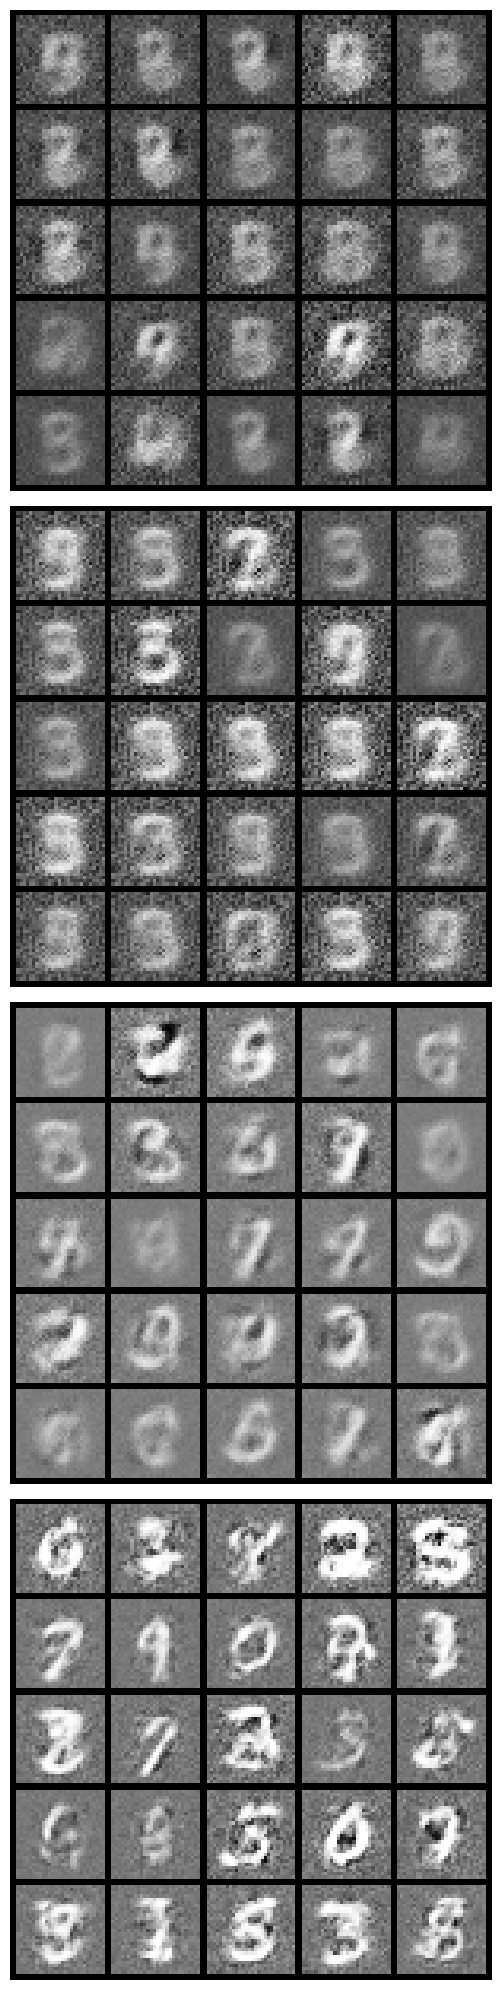

In [76]:
image_paths = [
    '../result/3-0.png',
    '../result/3-1000.png',
    '../result/3-10000.png',
    '../result/3-99000.png'
]

images = [Image.open(path) for path in image_paths]

fig, axes = plt.subplots(len(images), 1, figsize=(10, 20))

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [72]:
# Random smaple noise
z = random_sample_z_space(batch_size)

# Generate image
gen_imgs = generator(z)

# visualize
utils.save_image(gen_imgs.data[:25].cpu().detach(), '../result/4-gen_imgs.png', nrow=5, normalize=True)

**Save model weights**

In [73]:
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict: ': generator.state_dict(),
    'model_D_state_dict: ': discriminator.state_dict(),
    'optimizer_G_state_dict: ': optimizer_G.state_dict(),
    'optimizer_D_state_dict: ': optimizer_D.state_dict(),
}, '../result/5-model.pth')

### Visualization (Interpolation)

**Interpolation 보간**  
GAN모델을 이용해 interpolation을 하면, 주어진 두 개의 latent space 벡터 사이의 값을 생성한다.  
두 latent space vector $z_1$과 $z_2$ 사이를 interpolation하면, $z_1$과 $z_2$를 잇는 선을 따라 중간 벡터들을 계산한다. 각 중간 벡터 $z_t$를 GAN의 generator에 입력하면, 그에 해당하는 중간 이미지를 생성할 수 있다. $z_1$에서 $z_2$로 변하는 일련의 이미지들을 얻을 수 있다.  

이 과정을 통해 두 이미지 간의 자연스러운 변화를 시각화할 수 있다. 예를 들어 두 사람의 얼굴 이미지 사이를 interpolation하면, 한 사람의 얼굴에서 다른 사람의 얼굴로 변하는 일련의 이미지를 얻을 수 있다. 이 방법은 GAN 모델이 학습한 latent space가 어떻게 구조화되어 있는지 이해하는데 도움이 된다.

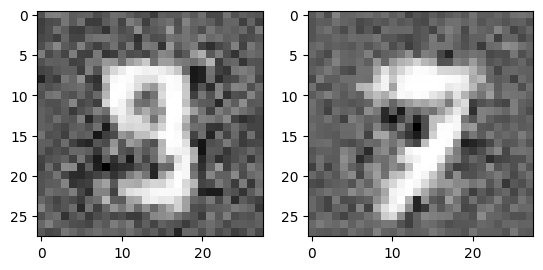

In [74]:
z_opposites = random_sample_z_space(2)
fake_img = generator(z_opposites)

plt.subplot(121)
plt.imshow(fake_img[0].squeeze().cpu().detach(), cmap='gray')
plt.subplot(122)
plt.imshow(fake_img[1].squeeze().cpu().detach(), cmap='gray')

plt.savefig('../result/5-side-images.png', dpi=300)

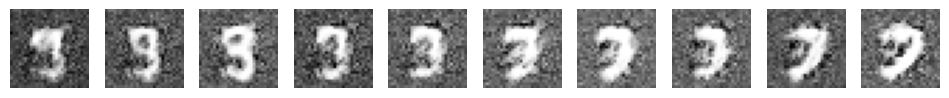

In [75]:
num_interpolation = 10

z_interpolation = Variable(Tensor(np.linspace(z_opposites[0].cpu(), z_opposites[1].cpu(), num_interpolation)))
fake_img = generator(z_interpolation)

plt.figure(figsize=(12,2))
for i in range(num_interpolation):
    plt.subplot(1,num_interpolation,i+1)
    plt.imshow(fake_img[i].squeeze().cpu().detach(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig('../result/6-interpolation.png', dpi=300)